In [69]:
import os
import h5py
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import morphology, filters
import skfuzzy as fuzz
from sklearn.cluster import KMeans

In [70]:
def load_image_data(filename, attribute):
    if not os.path.exists(filename):
        raise FileNotFoundError(f"The file {filename} does not exist.")

    with h5py.File(filename, 'r') as f:
        image = f[attribute][:]
    return image

def saveImage(segmented_image, final_mask):
    current_path = os.getcwd()
    with h5py.File(os.path.join(current_path, 'maskedImage.h5'), 'w') as hf:
        hf.create_dataset('Image', data=segmented_image)

    with h5py.File(os.path.join(current_path, 'Mask.h5'), 'w') as hf:
        hf.create_dataset('Image', data=final_mask.astype(np.uint8)*255)

def colorSpace(image, name):
    colorSpaceImage = cv2.cvtColor(image, name)
    c1, c2, c3 = cv2.split(colorSpaceImage)
    return c1, c2, c3


def display_images(images, titles, cmap=None, figsize=(15, 5)):
    
    if cmap is None:
        cmap = [None] * len(images)
    
    if cmap == 'viridis':
        cmap = ['viridis'] * len(images)
            
    if cmap == 'gray':
        cmap = ['gray'] * len(images)
        
    fig, ax = plt.subplots(ncols=len(images), figsize=figsize)
    for i in range(len(images)):
        ax[i].imshow(images[i], cmap=cmap[i])
        # filename = f"{titles[i].replace(' ', '_')}.png"
        # plt.imsave(filename, images[i], cmap=cmap[i])
        ax[i].set_title(f'{titles[i]}')
        ax[i].axis('off')
    plt.show()

def display_histogram(channels, titles, colors, figsize=(15, 5)):
    fig, ax = plt.subplots(ncols=len(channels), figsize=figsize)
    for i in range(len(channels)):
        ax[i].hist(channels[i][channels[i]>0].flatten(), bins=256, color= colors[i])
        ax[i].set_title(f'histogram of {titles[i]}')
        # Remove ticks and labels
        ax[i].tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False, labelbottom=True, labelleft=False)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()



<Figure size 640x480 with 0 Axes>

In [71]:
def apply_triangle_threshold(image, channel):
    thresholdValue, threshold = cv2.threshold(channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
    masked_image = cv2.bitwise_and(image, image, mask=threshold)
    return thresholdValue, threshold, masked_image

def apply_manual_threshold(image, value, channel):
    thresholdValue, threshold = cv2.threshold(channel, value, 140, cv2.THRESH_BINARY)
    masked_image = cv2.bitwise_and(image, image, mask=threshold)
    return thresholdValue, threshold, masked_image

def apply_Otsu_threshold(image, channel):
    thresholdValue, threshold = cv2.threshold(channel, 138, 255, cv2.THRESH_BINARY )
    masked_image = cv2.bitwise_and(image, image, mask=threshold)
    return thresholdValue, threshold, masked_image

def apply_niblack_threshold(threshold_image, window_size=51, k_value=-0.2):
    niblack_thresh = filters.threshold_niblack(threshold_image, window_size=window_size, k=k_value)
    niblack_mask = threshold_image > niblack_thresh
    combined_mask = threshold_image & ~niblack_mask
    return niblack_mask, combined_mask

def apply_morphological_operations(combined_mask, erosion_range=30, dilation_range=60):
    erosion_mask = np.zeros_like(combined_mask).astype(bool)
    morphology.binary_erosion(
        morphology.binary_erosion(combined_mask.astype(int), np.ones((1, erosion_range))),
        np.ones((erosion_range, 1)),
        out=erosion_mask
    )

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosion_mask.astype(np.uint8), connectivity=8)
    mask = np.zeros_like(erosion_mask)

    min_area = 0
    max_area = 10000

    for i in range(num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        # print(f"Label {i}: Area = {area}")
        if min_area < area < max_area:
            mask[labels == i] = 255

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
    eroded_mask = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
    cleaned_image = cv2.subtract(erosion_mask.astype(np.uint8), eroded_mask)

    dilation_mask = np.zeros_like(cleaned_image).astype(bool)
    morphology.binary_dilation(
        morphology.binary_dilation(cleaned_image.astype(int), np.ones((1, dilation_range))),
        np.ones((dilation_range, 1)),
        out=dilation_mask
    )
    
    return erosion_mask, cleaned_image, dilation_mask

In [72]:
# image = load_image_data(filename, '/Image')

# read blockface image from hdf5 file
#filename = '/mnt/g/Implementation/Segmentation/working/Registered/PE-2021-00981-H_00_s0908_BF_Raw_Registered_Flat_v000.h5'
# filename = '/mnt/g/Data/Blockface/s0900-s0920_unregistered_5ExpTimes/PE-2021-00981-H_00_s0920_BF_Raw_Flat_v000.h5'
# filename = '/mnt/g/Data/hdf5/PE-2021-00981-H_00_s0920_BF_Raw_Registered_Flat_v000.h5'
filename = '/mnt/g/Data/Conventional/20/PE-2021-00981-H_00_s0260_BF_Raw_Registered_Flat_v002.h5'

file = h5py.File(filename, 'r')
imageH5 = np.array(file['/Image'])
print('image shape: ', imageH5.shape)
exposure_time   = file['/Image'].attrs['exposure_time']
print('exposure time: ', exposure_time)    
# plt.imshow(image, cmap='gray')

image shape:  (3648, 5472, 3)
exposure time:  20


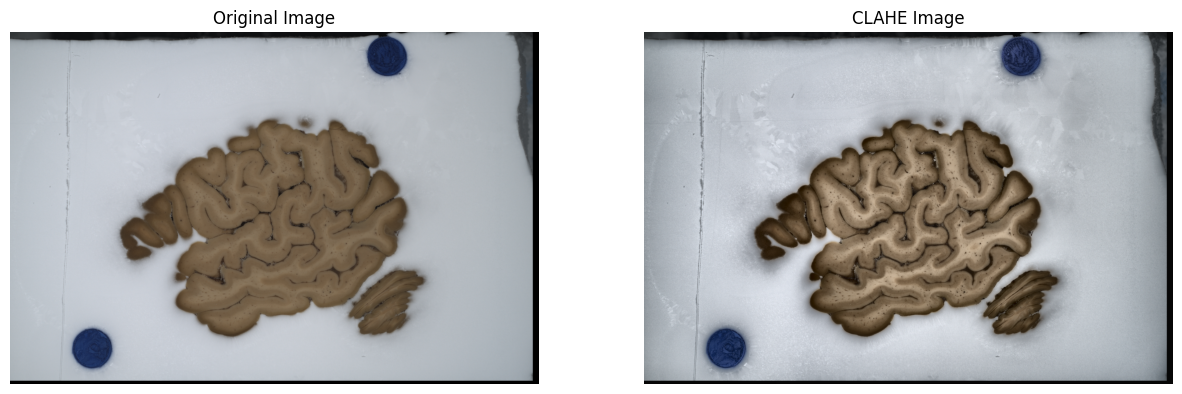

In [73]:
image = imageH5
# Create a CLAHE object
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
image[:, :, 0] = clahe.apply(image[:, :, 0])
image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)

# Segmented = Image.fromarray(image)
# Segmented.save('clahe.png', dpi=(300, 300))
images = [imageH5,image]
titles = ['Original Image', 'CLAHE Image']
display_images(images, titles)


# Segmented = Image.fromarray(image)
# Segmented.save('image.png', cmap='gray', dpi=(300, 300))

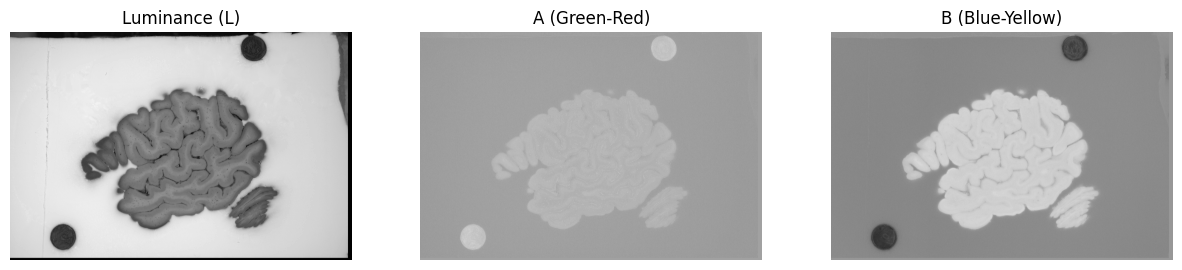

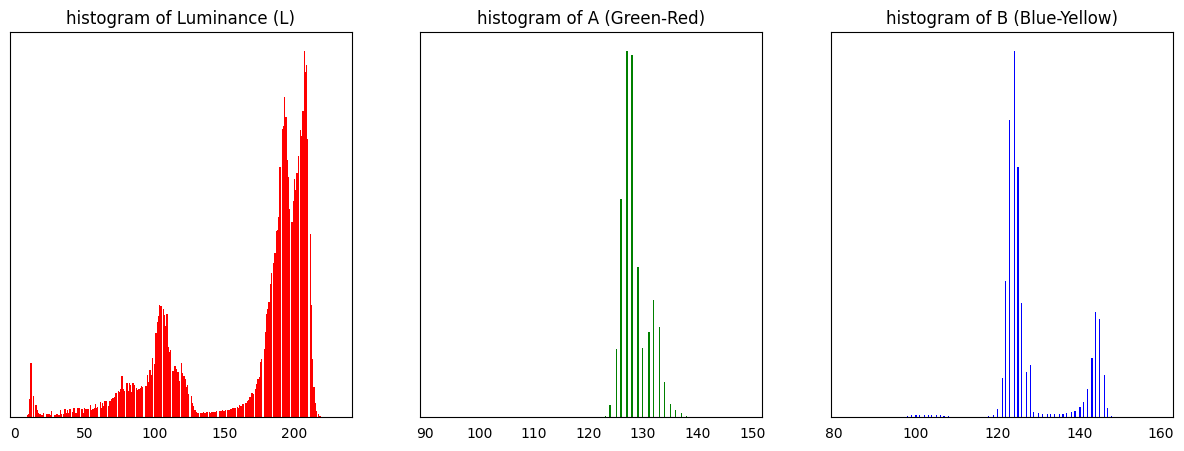

In [74]:
L, A, B = colorSpace(imageH5, cv2.COLOR_RGB2LAB)
# Titles for each channel
channel_titles = ['Luminance (L)', 'A (Green-Red)', 'B (Blue-Yellow)']
channels = [L, A, B]
colors = ['r', 'g', 'b']

# Calculate the histogram
hist = cv2.calcHist([B], [0], None, [256], [0, 256]).ravel()
display_images(channels, channel_titles, cmap = 'gray')
display_histogram(channels, channel_titles, colors)


Threshold value:  138.0


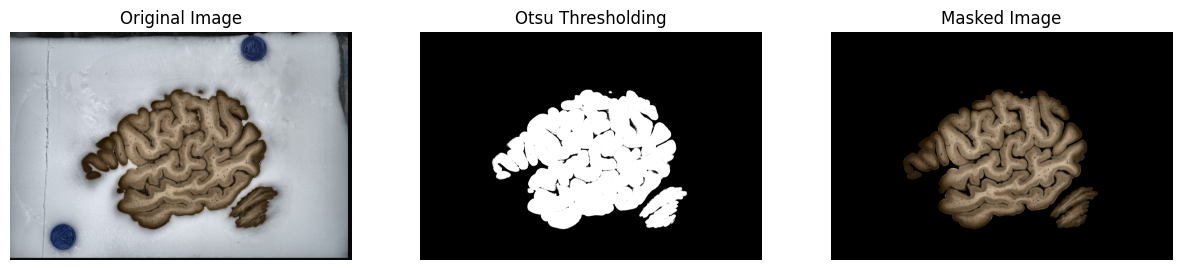

In [75]:
value, threshold, masked_image = apply_Otsu_threshold(image, B)
print('Threshold value: ', value)
thresholdImages = [image, threshold, masked_image]
titles = ['Original Image', 'Otsu Thresholding', 'Masked Image']
display_images(thresholdImages, titles, cmap = 'gray')
# Segmented = Image.fromarray(threshold)
# Segmented.save('otsu.png', cmap='gray', dpi=(300, 300))

In [76]:
# fig, ax = plt.subplots(ncols = 2, figsize=(15, 5)) 
# ax[0].imshow(B)
# ax[0].set_title('B channel')
# ax[0].axis('off')
# ax[1].hist(B[B>0].flatten(), bins=256, color= 'b')
# ax[1].set_title('histogram of B channel')
# plt.axvline(value, color='r')

In [77]:
# value, threshold, masked_image = apply_triangle_threshold(image, B)
# print('Threshold value: ', value)
# thresholdImages = [image, threshold, masked_image]
# titles = ['Original Image', 'Thresholded Image (Triangle Method)', 'Masked Image']
# display_images(thresholdImages, titles, cmap = 'gray')



In [78]:

# niblack_mask, combined_mask = apply_niblack_threshold(threshold)
# masks = [threshold, niblack_mask, combined_mask]
# maskTitles = ['Triangle Thresholding', 'Niblack Mask', 'Combined Mask (Triangle & Niblack)']
# display_images(masks, maskTitles, cmap ='gray')


In [79]:
# Apply morphological operations
#5, 2 -#200
#10,50 -#100
#combined_mask or threshold or niblack_mask
# # otsu alone 

# # 3rd IMage  - 3, 10
# erosion_mask, cleaned_image, dilation_mask = apply_morphological_operations(threshold, 2, 10)
# morphologyMasks = [threshold, erosion_mask, cleaned_image, dilation_mask]
# maskTitles = ['Mask', 'Eroded Mask', 'Refined Mask', 'Dilated Mask']
# display_images(morphologyMasks, maskTitles, cmap = 'gray')

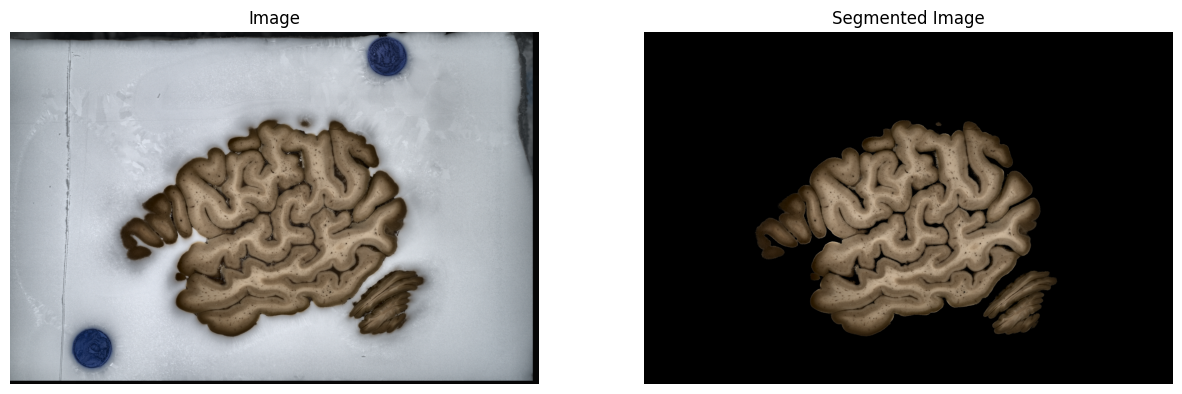

In [80]:
# Segmented = Image.fromarray(threshold)
# Segmented.save('threshold.png', cmap='gray', dpi=(300, 300))
dilation_mask = threshold
segmented_image = cv2.bitwise_and(image, image, mask=dilation_mask.astype(np.uint8)*255)
# segmented_image = np.copy(masked_image)
# segmented_image[mask.astype(int) == 0] = 0
display_images([image, segmented_image], ['Image', 'Segmented Image'])
# Segmented = Image.fromarray(segmented_image)
# Segmented.save('sImage.png', cmap='gray', dpi=(300, 300))


In [81]:

# # final_mask = Image.fromarray(dilation_mask)
# # final_mask.save('finalMask.png', dpi=(300, 300))
# final_mask = dilation_mask.astype(np.uint8)
# contours, hierarchy = cv2.findContours(final_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contour_image = np.copy(image)
# cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 6)
# display_images([segmented_image, contour_image], ['Segmented Image', 'Contours'], cmap=[None, None])

In [82]:

def segment_part_fcm(part_image, n_clusters):
    pixels = part_image.reshape((-1, 1))
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        pixels.T, n_clusters, 2, error=0.005, maxiter=1000, init=None)
    labels = np.argmax(u, axis=0).reshape(part_image.shape)
    return labels, cntr


# Function to create a multi-class mask based on centroids for a single part

def segment_part_kmeans(part_image, n_clusters):
    pixels = part_image.reshape((-1, 1))  
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    labels_image = labels.reshape(part_image.shape)
    return labels_image, kmeans.cluster_centers_

# Function to create a multi-class mask based on centroids for a single part
def create_multi_class_mask(part_labels, centroids):
    brightness = centroids.flatten() 
    mask = np.zeros_like(part_labels, dtype=np.uint8)  # Initialize mask
    mask[(part_labels == np.argmin(brightness))] = 0  # The cluster with the smallest brightness -> 0
    mask[(part_labels == np.argsort(brightness)[1])] = 100  # The second cluster -> 100
    mask[(part_labels == np.argsort(brightness)[2])] = 255  # The third cluster -> 255
    
    return mask

height, width = segmented_image.shape[:2]
h_mid, w_mid = height // 2, width // 2
gray_brain_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2GRAY)
parts = [
    gray_brain_image[0:h_mid, 0:w_mid],     # Top-left
    gray_brain_image[0:h_mid, w_mid:width],  # Top-right
    gray_brain_image[h_mid:height, 0:w_mid], # Bottom-left
    gray_brain_image[h_mid:height, w_mid:width]  # Bottom-right
]


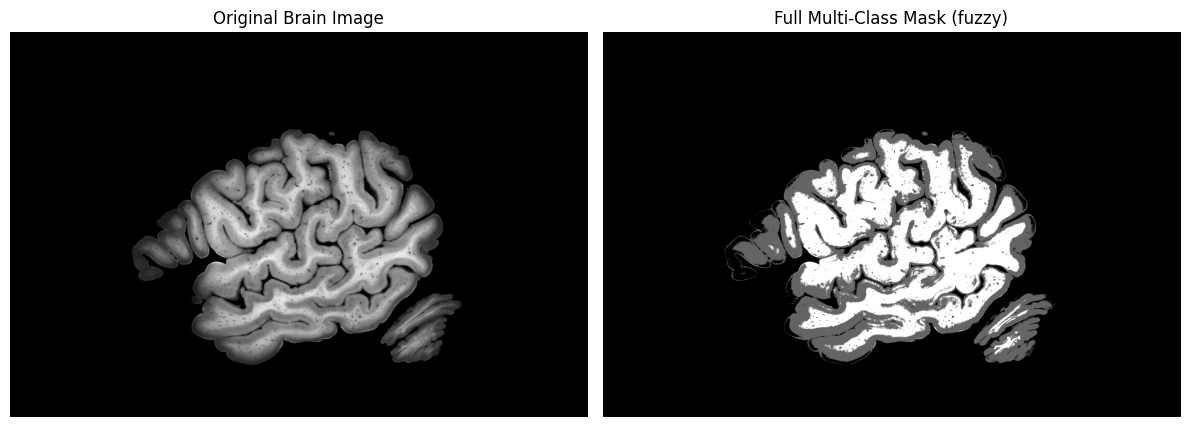

In [83]:
n_clusters = 3  # Number of clusters (background, gray matter, white matter)
fuzzy_parts = []
fuzzy_mask = []
for part in parts:
    part_labels, centroids = segment_part_fcm(part, n_clusters) 
    multi_class_mask = create_multi_class_mask(part_labels, centroids)  # Create multi-class mask
    fuzzy_parts.append(part_labels)
    fuzzy_mask.append(multi_class_mask)

# Reconstruct the full multi-class mask from the segmented parts
top_f = np.hstack((fuzzy_mask[0], fuzzy_mask[1]))  # Top row
bottom_f = np.hstack((fuzzy_mask[2], fuzzy_mask[3]))  # Bottom row
fuzzyFullMask = np.vstack((top_f, bottom_f))  # Combine top and bottom into full mask

final_mask = Image.fromarray(fuzzyFullMask)
final_mask.save('multiclassMetric/Pred/ohneMorph/multiMask1.png', dpi=(300, 300))
# final_mask.save('multiclassMetric/Pred/Morph/multiMask5.png', dpi=(300, 300))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gray_brain_image, cmap='gray')
plt.axis('off')
plt.title('Original Brain Image')

plt.subplot(1, 2, 2)
plt.imshow(fuzzyFullMask, cmap='gray')  # Display using a colormap for clarity
plt.axis('off')
plt.title('Full Multi-Class Mask (fuzzy)')

plt.tight_layout()
plt.show()

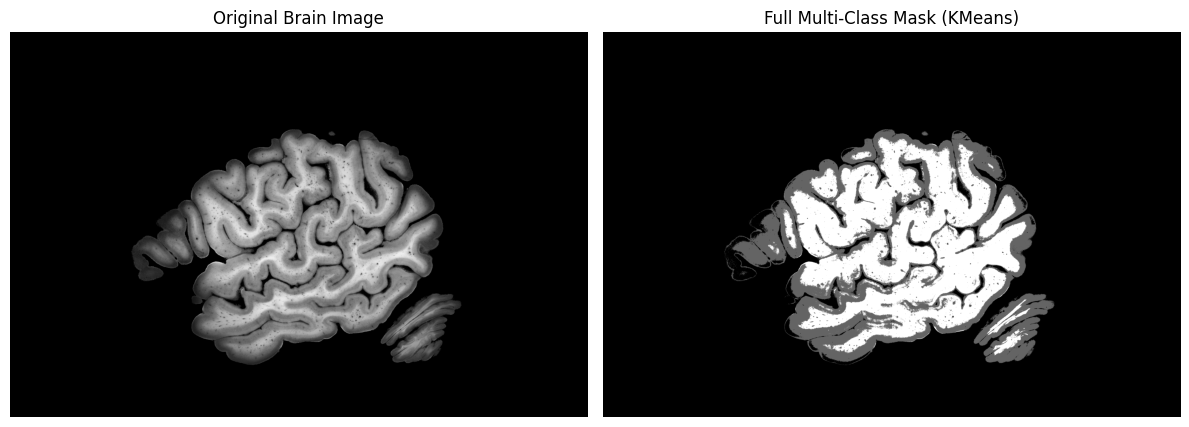

In [84]:
kmeans_parts = []
kmeans_mask = []

for part in parts:
    part_labels, centroids = segment_part_kmeans(part, n_clusters) 
    multi_class_mask = create_multi_class_mask(part_labels, centroids)  # Create multi-class mask
    kmeans_parts.append(part_labels)
    kmeans_mask.append(multi_class_mask)

# Reconstruct the full multi-class mask from the segmented parts
top_k = np.hstack((kmeans_mask[0], kmeans_mask[1]))  # Top row
bottom_k = np.hstack((kmeans_mask[2], kmeans_mask[3]))  # Bottom row
kmeansFullMask = np.vstack((top_k, bottom_k))  # Combine top and bottom into full mask

final_mask = Image.fromarray(kmeansFullMask)
final_mask.save('multiclassMetric/Pred/ohneMorph/kmultiMask1.png', dpi=(300, 300))
# final_mask.save('multiclassMetric/Pred/Morph/kmultiMask5.png', dpi=(300, 300))

# Save the full multi-class mask
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gray_brain_image, cmap='gray')
plt.axis('off')
plt.title('Original Brain Image')

plt.subplot(1, 2, 2)
plt.imshow(kmeansFullMask, cmap='gray')  
plt.axis('off')
plt.title('Full Multi-Class Mask (KMeans)')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'white matter')

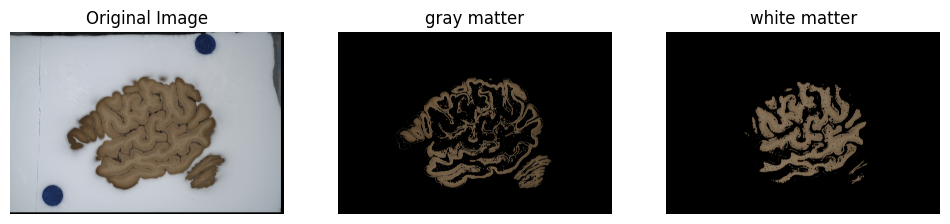

In [85]:
filename = '/mnt/g/Data/Conventional/20/PE-2021-00981-H_00_s0260_BF_Raw_Registered_Flat_v002.h5'
file = h5py.File(filename, 'r')
imageH5 = np.array(file['/Image'])
grayMatter = np.copy(imageH5)
whiteMatter = np.copy(imageH5)
mask = cv2.imread('multiclassMetric/Pred/ohneMorph/multiMask1.png', cv2.COLOR_GRAY2BGR)
gm = (mask == 100)
wm = (mask == 255)
grayMatter[~gm] = 0 
whiteMatter[~wm] = 0 
gm1 = Image.fromarray(grayMatter)
gm1.save('multiclassMetric/Pred/ohneMorph/gm1.png', dpi=(300, 300))
wm1 = Image.fromarray(whiteMatter)
wm1.save('multiclassMetric/Pred/ohneMorph/wm1.png', dpi=(300, 300))

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(imageH5, cmap='gray')
plt.axis('off')
plt.title('Original Image')

# Display the mask for value 100
plt.subplot(1, 3, 2)
plt.imshow(grayMatter, cmap='gray')
plt.axis('off')
plt.title('gray matter')

# Display the mask for value 255
plt.subplot(1, 3, 3)
plt.imshow(whiteMatter, cmap='gray')
plt.axis('off')
plt.title('white matter')